In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import geopandas as gpd
from shapely.geometry import Point, Polygon

# At first we mount the dataset from local file

inputdf = pd.read_csv('Crime.csv')

In [ ]:


# sneak peak in the data
inputdf.head(2)


In [ ]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns
inputdf.dtypes

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [ ]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

# Later, Columns related with the effect of crime are removed.

In [ ]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Now we have to visualize the data and fix what to predict from these modified feature set

In [ ]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


In [ ]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()

In [ ]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()

In [ ]:
# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

In [ ]:
inputdf['Crime Name2'].value_counts()

# Export Pandas DataFrame to CSV


In [ ]:

# inputdf.to_csv('potential feature set revised.csv')


# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [ ]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

In [ ]:
geo_df.plot()

# Visualizing the Crime Data

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
# plt.savefig('Crime Heat Map for Location')

In [ ]:
#geo_df['Crime Name1'].hist()
geo_df['Crime Name2'].count()
geo_df['Crime Name2'].value_counts()
# geo_df.groupby('Crime Name2').count() # per group data count


#geo_df['Latitude'].hist()

# Separating Train and Test Set for Crime Prediction for Location

In [740]:
print(inputdf['Crime Name1'].value_counts())

Crime Against Property    140262
Crime Against Society      66848
Other                      62981
Crime Against Person       30221
Not a Crime                 3590
Name: Crime Name1, dtype: int64


# Creating The Location Based Crime Data Frame

In [741]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,21,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,8,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,3,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,3,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,16,7


In [742]:
print(loc_crime_df.shape)
loc_crime_df.dtypes

(304175, 12)


Crime Name1              object
Crime Name2              object
Police District Name     object
City                     object
Zip Code                float64
Place                    object
Street Name              object
Latitude                float64
Longitude               float64
dateHour                  int64
day                       int64
month                     int64
dtype: object

In [743]:
# # Taking only Top n classes in a column
# target_column = 'Crime Name1'
# top_n = 2 
# # using .astype(int)

# loc_crime_df[target_column] = pd.to_numeric(loc_crime_df[target_column], errors='coerce')
# d = loc_crime_df.nlargest(top_n, target_column)
# print(d)
# print(d[target_column].value_counts())


In [744]:
# Taking only Top n classes in a column
target_column = 'Crime Name1'
top_n = 2 
top_classes = {}
top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
# print(top_classes)
str_array = []
temp_df = pd.DataFrame()
for x in top_classes.keys():
    str_array.append(x)
    temp_df= loc_crime_df[loc_crime_df[target_column] == str (x) ]
# print(str_array)
temp_df


{'Crime Against Property': 140262, 'Crime Against Society': 66848}
['Crime Against Property', 'Crime Against Society']


In [745]:
print(temp_df[target_column].value_counts())
# print(loc_crime_df[target_column].value_counts())

Crime Against Society    66848
Name: Crime Name1, dtype: int64
Crime Against Property    140262
Crime Against Society      66848
Other                      62981
Crime Against Person       30221
Not a Crime                 3590
Name: Crime Name1, dtype: int64


In [746]:
# # Taking only Top n classes in a column
# target_column = 'Crime Name1'
# top_n = 2 
# # inputdf = inputdf[inputdf['Latitude'] > 35.0]

# top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n)
# print(top_classes)
# # Getting n+1 lowest classes
# # top_classes = loc_crime_df[target_column].value_counts()[top_n:].index
# str_array = []
# for x in range(top_n):
#     str_array.append(top_classes.at[x])
# # print(top_classes.index)
# # str_array = top_classes.to_string()
# print(str_array)

In [747]:
# loc_crime_df= loc_crime_df[loc_crime_df[target_column] in top_classes ]

# loc_crime_df[target_column].value_counts()

In [748]:
 # Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]



In [749]:
 # Removing Rows on Count condition 
 # Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)
loc_crime_df.head()
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)


# Dropping null values in Zip code

In [750]:
loc_crime_df['Zip Code'].value_counts()
# loc_crime_df['dateHour'].value_counts()

20910.0    21071
20902.0    17815
20906.0    14649
20904.0    14523
20874.0    14136
           ...  
20859.0        1
20914.0        1
2853.0         1
28017.0        1
20990.0        1
Name: Zip Code, Length: 148, dtype: int64

In [751]:
loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
print(loc_crime_df.shape)

(229017, 12)


In [752]:
# loc_crime_df['Crime Name2'].count()
# loc_crime_df['Crime Name2'].value_counts()

# Transform the data by label encoding

In [753]:
encoded_dict ={}
temp_df = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    #print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    #print(loc_crime_df[y])
    if y== 'Crime Name1':
        temp_df[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']
#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()

{}


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,1,34,8,34,20902.0,90,2705,39.036270,-77.049900,21,21,12
2,2,9,5,32,20850.0,92,2868,39.086688,-77.144754,2,3,1
4,1,37,2,19,20876.0,75,2580,39.198295,-77.244900,17,16,7
5,0,19,3,17,20879.0,58,6106,39.168194,-77.175049,14,21,9
6,2,32,5,32,20850.0,82,2580,39.103443,-77.155941,12,28,2


In [754]:
# print(loc_crime_df['Crime Name1'].value_counts())
# print(temp_df['Crime Name1'].value_counts())

In [755]:
# # Taking only Top n classes in a column - does not make sense
# target_column = 'Crime Name1'
# top_n = 2 
# print(loc_crime_df.nlargest(top_n, target_column))

# loc_crime_df[target_column] =  loc_crime_df.nlargest(top_n, target_column)
# print(loc_crime_df[target_column].value_counts())
# # loc_crime_df['Crime Name1'] =  loc_crime_df.nlargest(top_n, 'Crime Name1')
# # print(loc_crime_df['Crime Name1'].value_counts())

In [756]:
# temp_df = pd.DataFrame()
# def label_decoder(y):
#     #le = LabelEncoder()
#     for value in loc_crime_df[y]:
#         # finding key with value in dict
#         temp_df[y] = list(encoded_dict.keys())[list(encoded_dict.values()).index(value)]

# #loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

# #label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']
# label_list = ['Crime Name1']

# for l in label_list:
#     label_decoder(l)


# print(temp_df['Crime Name1'])

In [757]:
#Divide the dataset into independent and dependent variables
# X = loc_crime_df.drop([target_column],axis=1)
# y = loc_crime_df[target_column]

# X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column']


# Going for generic prediction
X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
y = loc_crime_df[target_column]

print(X)


        Police District Name  City  Zip Code  Place  Street Name  dateHour  \
0                          8    34   20902.0     90         2705        21   
2                          5    32   20850.0     92         2868         2   
4                          2    19   20876.0     75         2580        17   
5                          3    17   20879.0     58         6106        14   
6                          5    32   20850.0     82         2580        12   
...                      ...   ...       ...    ...          ...       ...   
312289                     8    34   20902.0     74         6863        13   
312290                     3    26   20886.0     51         4078        23   
312292                     0     5   20814.0     13         7319        12   
312295                     3    17   20877.0     80         5753        11   
312296                     6    34   20910.0     75         1526        17   

        day  month  
0        21     12  
2         3      1  


In [758]:
print(y.value_counts())

1    138559
2     56619
0     29791
3      3564
4       484
Name: Crime Name1, dtype: int64


In [759]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (183213, 8)
X_test shape: (45804, 8)
y_train shape: (183213,)
y_test shape: (45804,)


In [760]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# We will build all six models and compare their accuracy scores.



In [761]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [762]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)
    

Naïve Bayes Classifier is running
Train Score: 0.6550572336533939
Test Score: 0.6574316653567374


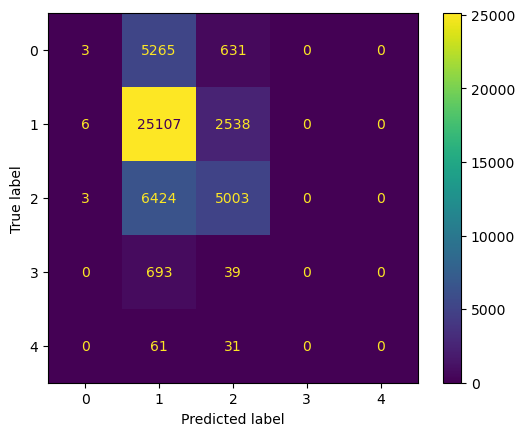

Decision Tree Classifier is running
Train Score: 0.6558923157336964
Test Score: 0.6604445026635228


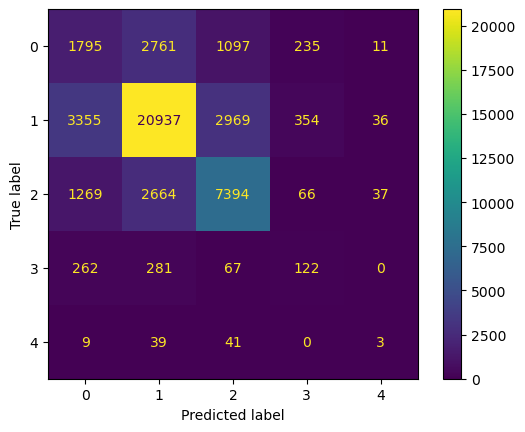

KNN Classifier is running
Train Score: 0.6513566217263508


KeyboardInterrupt: 

In [763]:
for model_name, model_function in models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))

    #Confusion matrix
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()


    #Store results in the dictionaries
    result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)
    


In [ ]:
# lengthy_models = {'Support Vector Classifier': SVC,
#         'Random Forest Classifier': RandomForestClassifier}
# for model_name, model_function in lengthy_models.items():
#     print(model_name +' is running')
#     try:
#         model = model_function(random_state = 42)
#     except:
#         model = model_function()
#     accuracies = cross_val_score(model, X_train, y_train, cv=5)
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)

#     #Obtain accuracy
#     print("Train Score:",np.mean(accuracies))
#     print("Test Score:",model.score(X_test,y_test))


#     # #Store results in the dictionaries
#     # result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
#     # result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)

# Compare Accuracy Scores

In [ ]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


# Display the accuracy scores

In [ ]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
#plt.show()
# plt.savefig('Predicting Specific Crime With Location')